In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from sklearn.datasets import make_gaussian_quantiles
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.utils import resample
import shap
from shap.maskers import Independent
from shap.plots import colors
from copy import deepcopy
import numpy as np
import pandas as pd
import pickle
import cloudpickle
from util import plot_decision_boundary, encode_one_hot, reduce_multiclass_proba_diff_shap_values, \
                 calc_log_odds_from_log_proba, calc_binary_log_odds_from_log_proba
from helper_models import RuleClassifier
from difference_models import BinaryDifferenceClassifier, MulticlassDifferenceClassifier
%matplotlib inline

# Setup Task

In [2]:
X, y = shap.datasets.adult()
feature_names = np.array(X.columns)
X = X.values
display_data = shap.datasets.adult(display=True)[0].values
X_explain, display_data_explain, y_explain = resample(X, display_data, y, replace=False, n_samples=15000, stratify=y, random_state=1)
n_features = len(feature_names)
n_samples = X.shape[0]

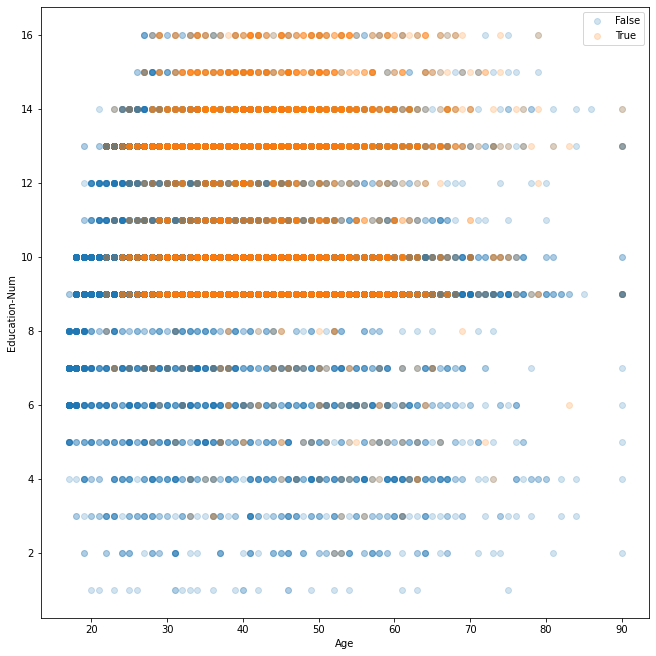

In [3]:
idx_x = 0
idx_y = 2
fig, ax = plt.subplots(figsize=(9, 9), constrained_layout=True)
for label in np.unique(y):
    data = display_data_explain[y_explain == label, :]
    ax.scatter(data[:, idx_x], data[:, idx_y], alpha=0.2, label=str(label))
ax.set_xlabel(feature_names[idx_x])
ax.set_ylabel(feature_names[idx_y])
ax.legend()
plt.show()

In [4]:
%%time
lm = LogisticRegression(C=1.0, max_iter=10000)
lm.fit(X, y)
lm.intercept_, lm.coef_

CPU times: user 15.9 s, sys: 1.4 s, total: 17.3 s
Wall time: 10.6 s


(array([-10.67088791]),
 array([[ 3.47166678e-02, -3.23667609e-02,  3.73211254e-01,
         -1.67530969e-01,  1.68002535e-02,  5.52219166e-01,
          1.07503643e-01,  6.95898436e-01,  3.28457284e-04,
          6.91619529e-04,  3.41287607e-02,  7.16219611e-03]]))

In [5]:
clf_a = lm

In [6]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels

class ModifiedClassifier(BaseEstimator, ClassifierMixin):
    
    def  __init__(self, base_model):
        self.base_model = base_model
        
    @property
    def classes_(self):
        return self.base_model.classes_
    
    def predict(self, X):
        return self.base_model.predict(self._preprocess(X))
    
    def predict_proba(self, X):
        return self.base_model.predict_proba(self._preprocess(X))
    
    def predict_log_proba(self, X):
        return self.base_model.predict_log_proba(self._preprocess(X))
    
    def _preprocess(self, X):
        X2 = X.copy()
        X2[(40 <= X[:, 0]) & (X[:, 0] < 50), 2] += 1
        return X2
    
clf_b = ModifiedClassifier(lm)

# Explain using Interpretability Methods

In [11]:
def explain(predict, X_explain, background_data, display_data_explain=None):
    masker = Independent(data=background_data)
    explainer = shap.Explainer(predict, masker, feature_names=feature_names)
    shap_values = explainer(X_explain)
    shap_values.display_data = display_data_explain
    return shap_values

Generate SHAP values for the classifiers $c_A$ and $c_B$:

In [12]:
%%time
predict_log_odds_a = lambda X: calc_binary_log_odds_from_log_proba(clf_a.predict_log_proba(X))
predict_log_odds_b = lambda X: calc_binary_log_odds_from_log_proba(clf_b.predict_log_proba(X))
shap_values_a = explain(predict_log_odds_a, X_explain=X_explain, background_data=X, display_data_explain=display_data_explain)
shap_values_b = explain(predict_log_odds_b, X_explain=X_explain, background_data=X, display_data_explain=display_data_explain)

divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in double_scalars
invalid value encountered in double_scalars
divide by zero encountered in log
invalid value encountered in double_scalars
invalid value encountered in double_scalars
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in double_scalars
invalid value encountered in double_scalars
divide by zero encountered in log
Permutation explainer:  16%|█▌        | 2379/15000 [00:24<01:53, 110.97it/s]divide by zero encountered in log
divide by zero encountered in log
Permutation explainer:  19%|█▉        | 2826/15000 [00:28<01:45, 115.33it/s]divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
Permutation explainer:  25%|██▍       | 3700/15000 [00:36<03:23, 55.44it/s] divide by zero encountered in log
divide by zero encountered in lo

CPU times: user 7min 28s, sys: 51 s, total: 8min 19s
Wall time: 6min 37s


In [22]:
has_finite_shap_values_a = np.all(np.isfinite(shap_values_a.values), axis=1)
has_finite_shap_values_b = np.all(np.isfinite(shap_values_b.values), axis=1)
is_finite_shap = has_finite_shap_values_a & has_finite_shap_values_b
shap_values_a = shap_values_a[is_finite_shap]
shap_values_b = shap_values_b[is_finite_shap]

Compute the actual differences of the SHAP values of $c_A$ and $c_B$ as a simple way to explain differences:

In [23]:
shap_values_a_vs_b = shap_values_b - shap_values_a
shap_values_a_vs_b.data = shap_values_a.data

Throughout the analysis, order features based on their importance for the differences:

In [24]:
feature_importance = shap_values_a_vs_b.abs.mean(axis=0)
feature_order = np.flip(feature_importance.values.argsort())

In [36]:
indices = np.arange(len(shap_values_a))
is_pred_diff = (clf_a.predict(X_explain) != clf_b.predict(X_explain))[is_finite_shap]
is_pred_equal = ~is_pred_diff

## Visualize SHAP values

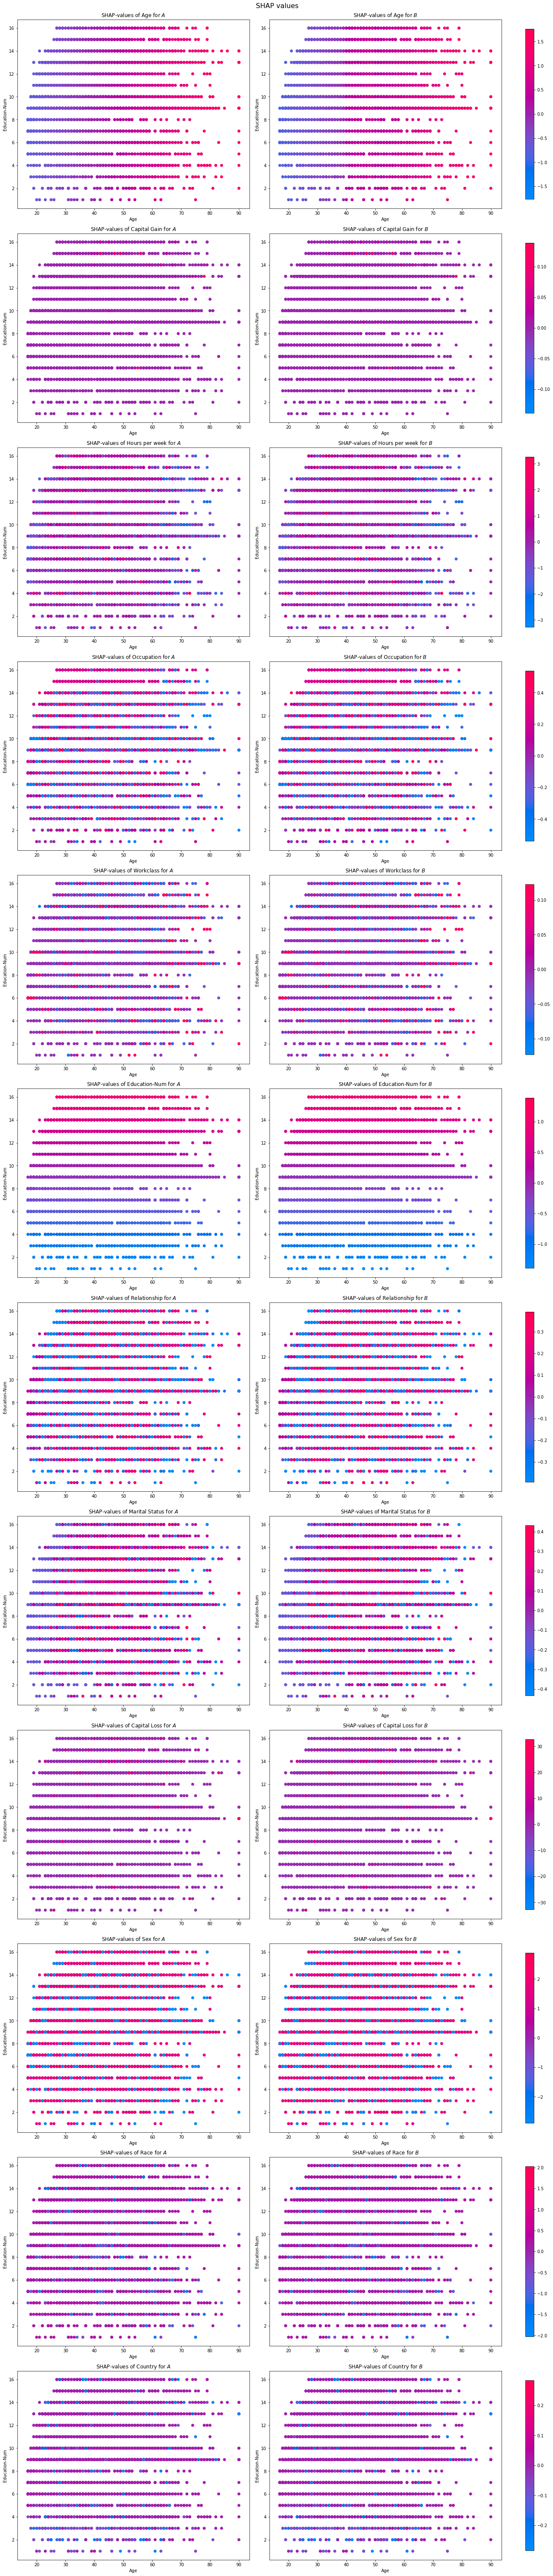

In [26]:
n_columns = 2
n_rows = n_features
fig, axs = plt.subplots(n_rows, n_columns, figsize=(9*n_columns, 7*n_rows), constrained_layout=True)
plot_idx = 0
fig.suptitle('SHAP values', fontsize=16)
for feature_idx in feature_order:
    vmax = np.max([np.max(np.abs(shap_values_a.values[:, feature_idx])),
                   np.max(np.abs(shap_values_b.values[:, feature_idx]))])
    for shap_values, model_title in [(shap_values_a, 'A'), (shap_values_b, 'B')]:
        ax = axs.flat[plot_idx]
        cs = ax.scatter(shap_values.display_data[:, 0],
                        shap_values.display_data[:, 2],
                        c=shap_values.values[:, feature_idx],
                        vmin=-vmax, vmax=vmax,
                        cmap=colors.red_blue,
                        alpha=1)
        ax.set_title(f'SHAP-values of {feature_names[feature_idx]} for ${model_title}$')
        ax.set_xlabel(feature_names[0])
        ax.set_ylabel(feature_names[2])
        plot_idx += 1
    fig.colorbar(cs, ax=axs[feature_idx].tolist(), shrink=0.9)
plt.show()

## Feature importance

### Bar plots

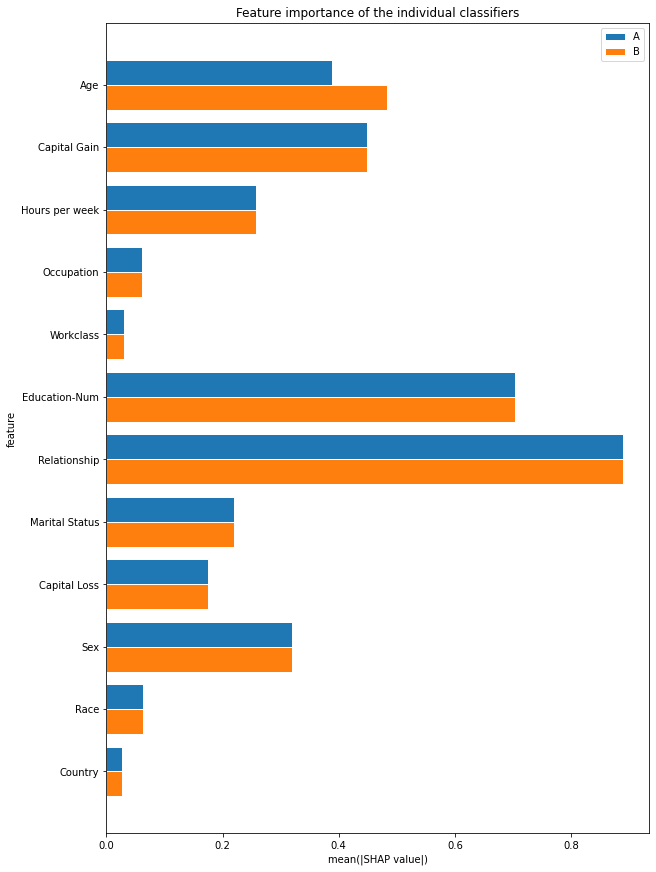

In [27]:
bar_width = 0.4
importances = np.array([shap_values_a.abs.mean(0).values.T, shap_values_b.abs.mean(0).values.T])
rects = [i * bar_width + np.arange(importances.shape[1]) for i in range(importances.shape[0])]
fig, ax = plt.subplots(figsize=(9, n_features), constrained_layout=True)
ax.set_title('Feature importance of the individual classifiers')
for name, rect, importance in zip(('A', 'B'), rects, importances[:, feature_order]):
    ax.barh(rect, importance, height=bar_width, edgecolor='white', label=name)
ax.set_ylabel('feature')
ax.set_xlabel('mean(|SHAP value|)')
ax.set_yticks([r + bar_width * (importances.shape[0] - 1)/2 for r in range(importances.shape[1])])
ax.set_yticklabels(feature_names[feature_order])
ax.invert_yaxis()
ax.legend()
plt.show()

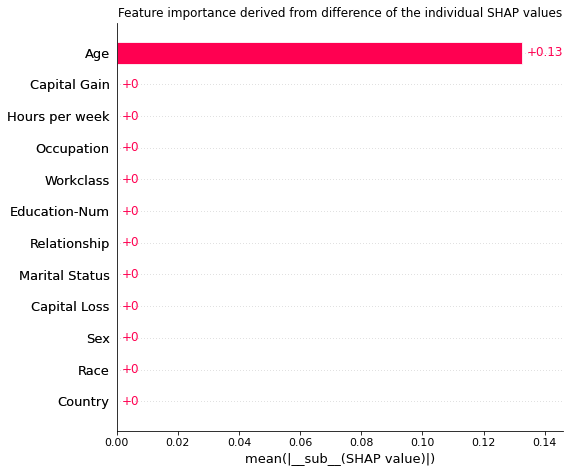

In [28]:
plt.title('Feature importance derived from difference of the individual SHAP values')
shap.plots.bar(shap_values_a_vs_b, order=feature_order, max_display=n_features)

### SHAP value distribution

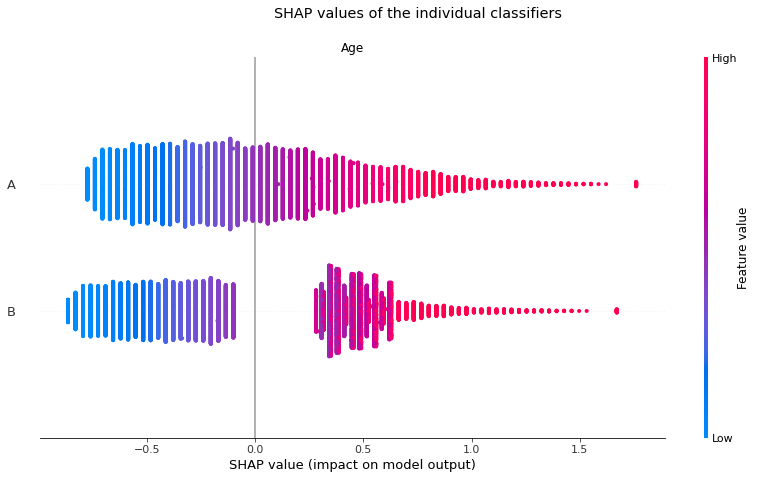

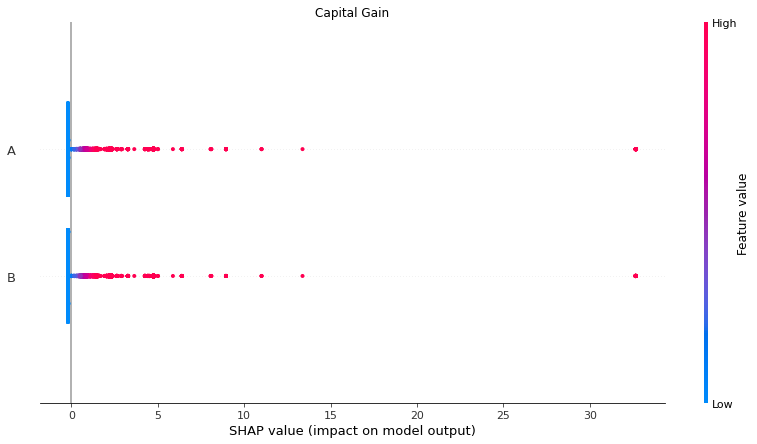

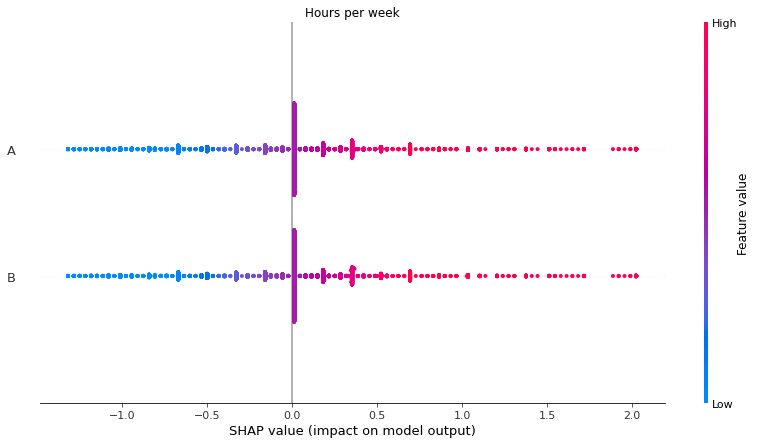

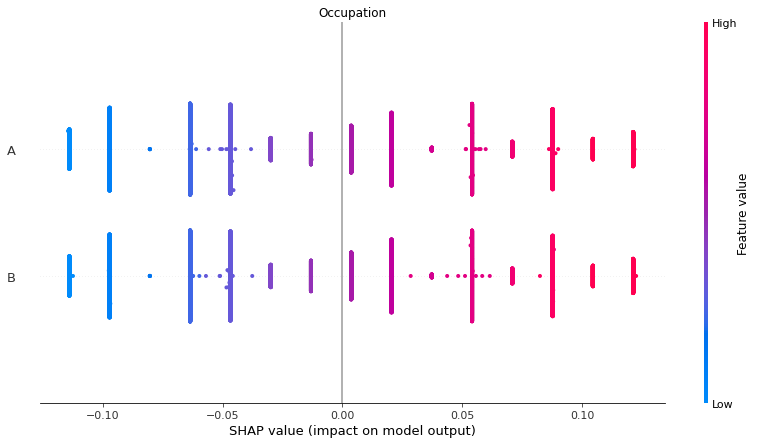

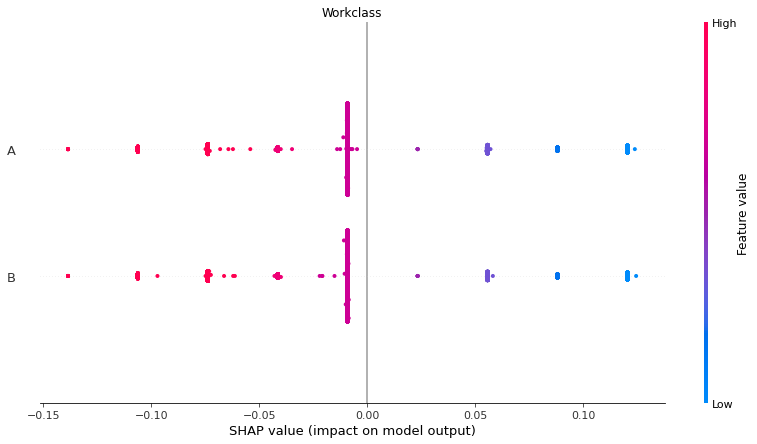

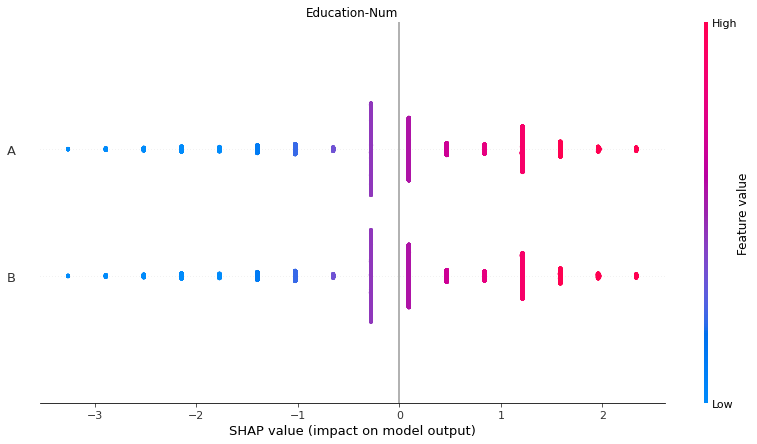

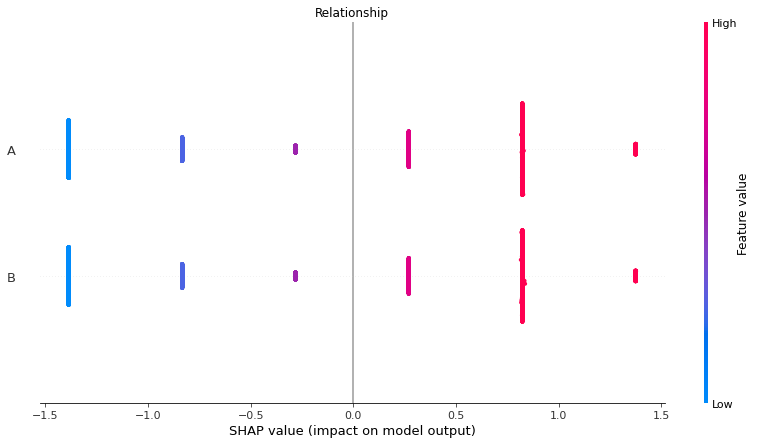

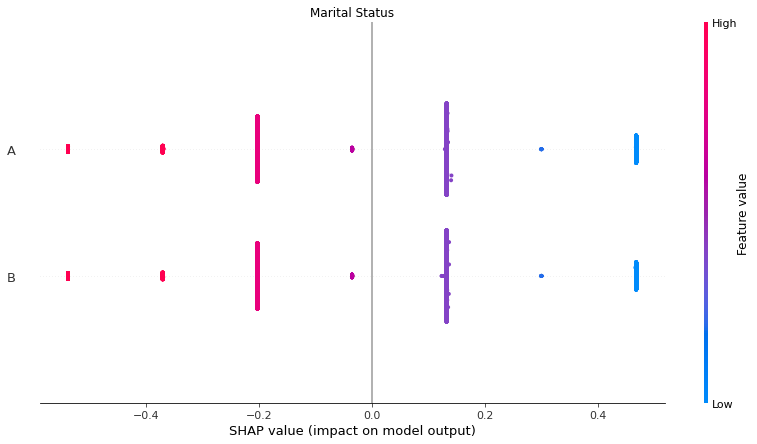

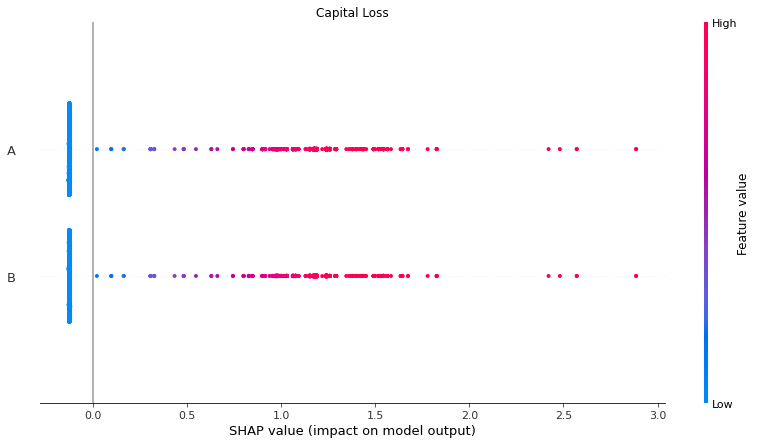

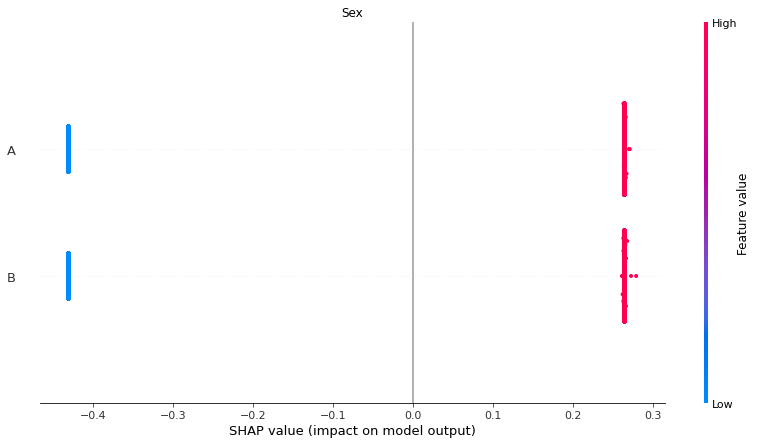

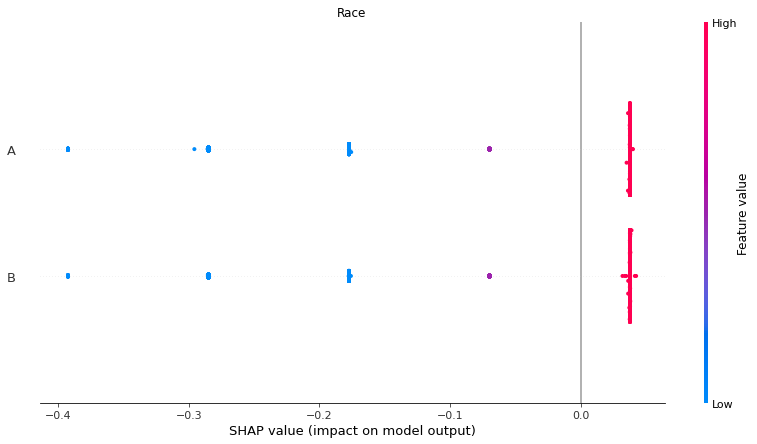

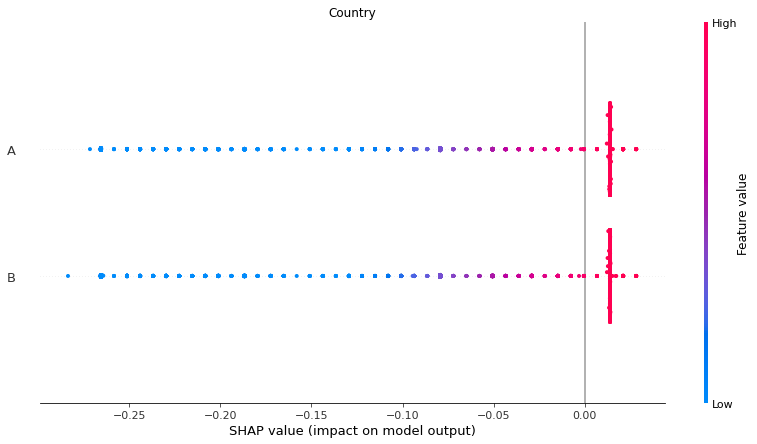

In [29]:
plt.suptitle('SHAP values of the individual classifiers', fontsize='x-large')
for feature_idx in feature_order:
    new_values = np.array([s.values[:, feature_idx] for s in (shap_values_a, shap_values_b)]).T
    new_data = np.array([s.data[:, feature_idx] for s in (shap_values_a, shap_values_b)]).T
    if shap_values_a.display_data is not None:
        new_display_data = np.array([s.display_data[:, feature_idx] for s in (shap_values_a, shap_values_b)]).T
    else:
        new_display_data = None
    new_base_values = np.array([s.base_values for s in (shap_values_a, shap_values_b)]).T
    shap_values_ = shap.Explanation(new_values, new_base_values, new_data, new_display_data, feature_names=['A', 'B'])
    shap.plots.beeswarm(shap_values_, plot_size=(14, 7), order=[0, 1], show=False)
    plt.title(feature_names[feature_idx])
    plt.show()

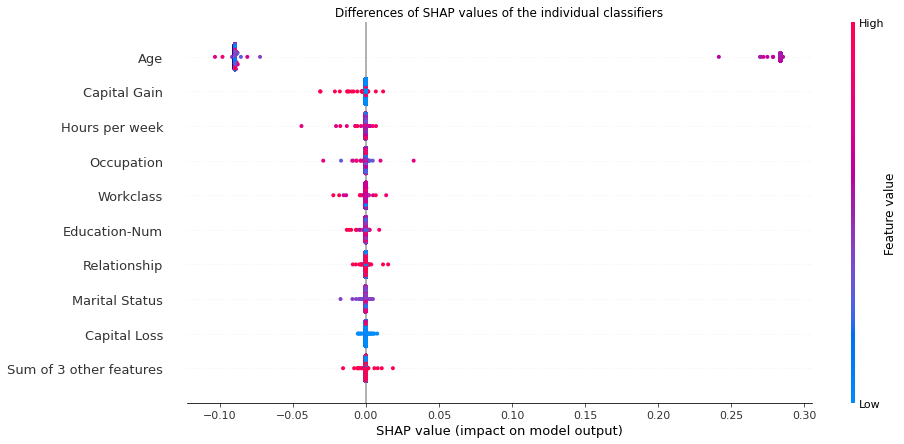

In [30]:
plt.title('Differences of SHAP values of the individual classifiers')
shap.plots.beeswarm(shap_values_a_vs_b, order=feature_order, plot_size=(14, 7))

## Feature effects

### Partial dependence plots

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


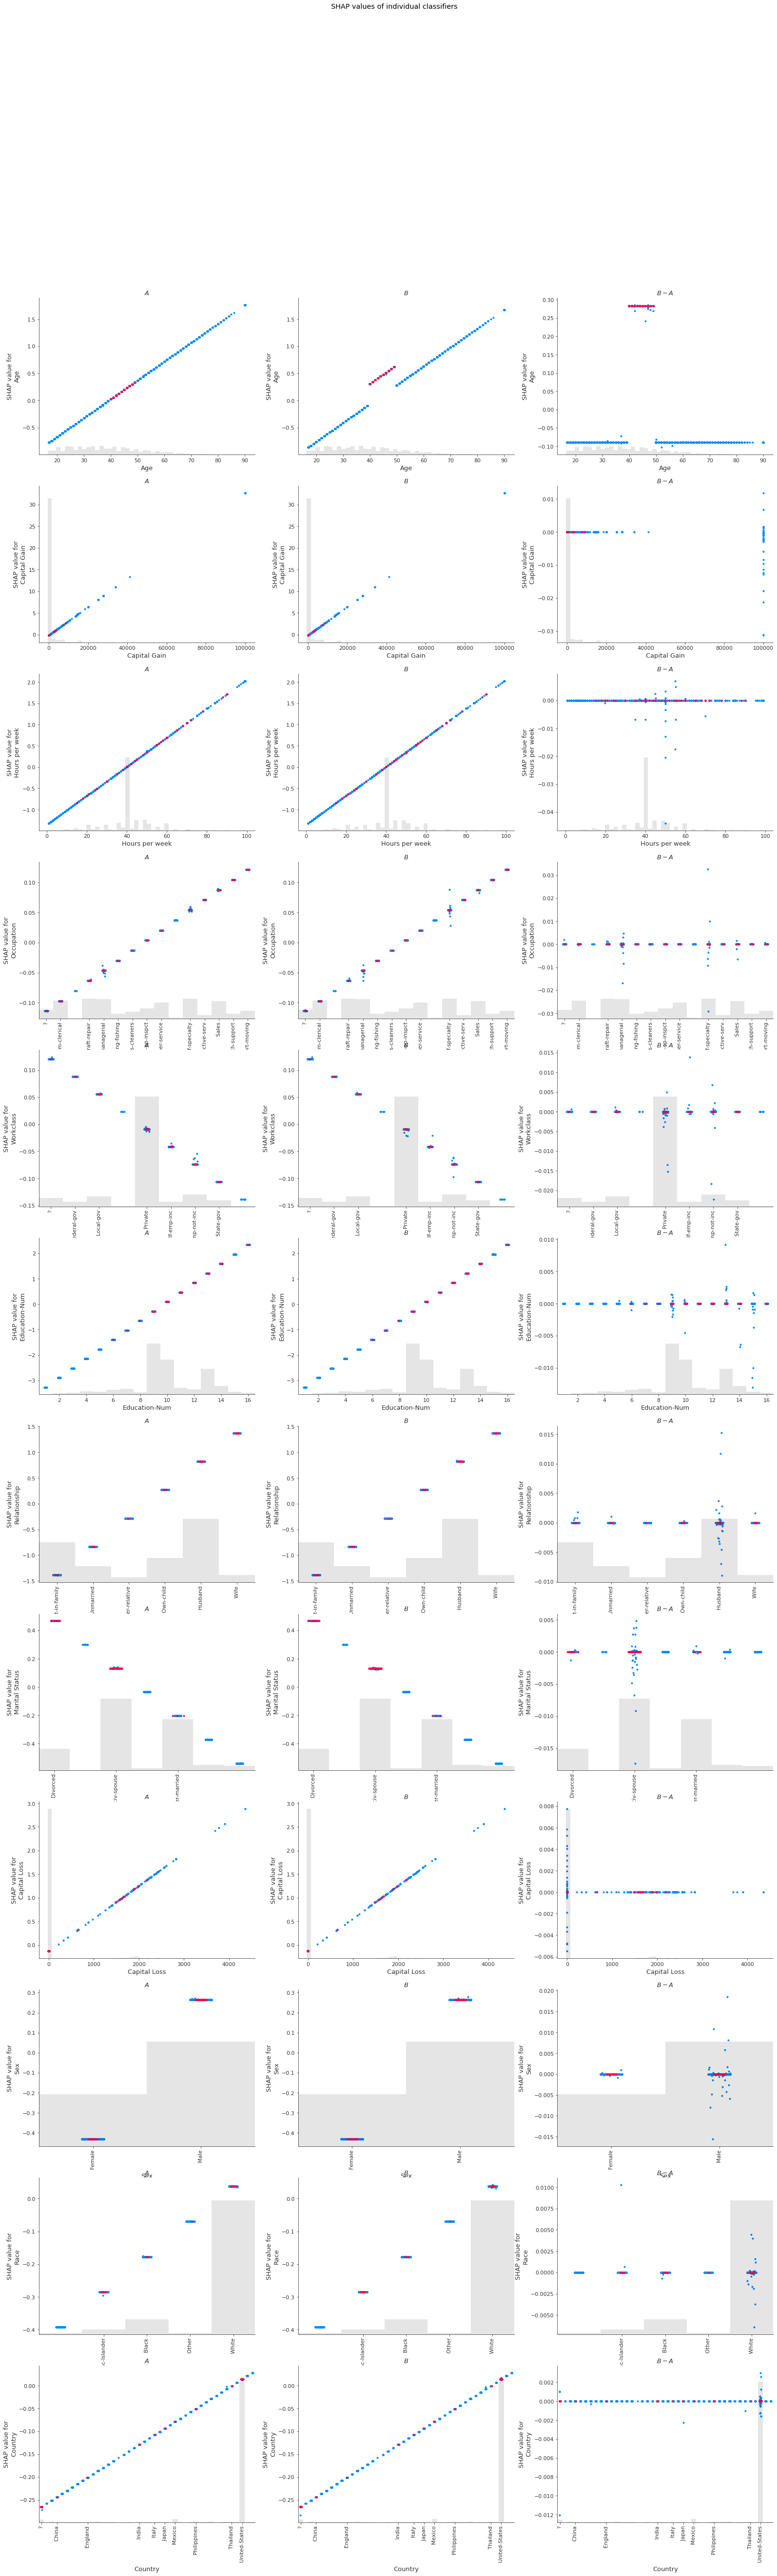

In [37]:
n_columns = 3
n_rows = n_features
fig = plt.figure(figsize=(9*n_columns, 7*n_rows))
fig.suptitle('SHAP values of individual classifiers', fontsize='x-large')
i = 1
for feature in feature_names[feature_order]:
    ax1 = fig.add_subplot(n_rows, n_columns, i)
    ax2 = fig.add_subplot(n_rows, n_columns, i+1, sharey=ax1)
    ax3 = fig.add_subplot(n_rows, n_columns, i+2)
    for title, ax, shap_values in [('$A$', ax1, shap_values_a),
                                   ('$B$', ax2, shap_values_b),
                                   ('$B-A$', ax3, shap_values_a_vs_b)]:
        shap.plots.scatter(shap_values[:, feature],
                           ax=ax,
                           color=tuple(colors.blue_rgb),
                           show=False)
        if np.sum(is_pred_diff) > 0:
            shap.plots.scatter(shap_values[is_pred_diff, feature],
                               title=title,
                               ax=ax,
                               color=tuple(colors.red_rgb),
                               hist=False,
                               show=False)
    i += n_columns
plt.show()